# Avaliação de desempenho preditivo
## com aplicações em conjuntos de dados

Nessa prática iremos utilizar o algoritmo KNN com diferentes distâncias e diferentes formas de avaliação, para as tarefas de classificação e regressão.

Para classificação utilizaremos o conjunto de dados de "Diagnóstico de Câncer de Mama de Wisconsin";
Para regressão utilizaremos o conjunto de dados de "Qualidade de Vinho Tinto".

Trabalhos científicos que utilizam essas bases:

Wisconsin Breast Cancer:
Brito-Sarracino, T., dos Santos, M. R., Antunes, E. F., de Andrade Santos, I. B., Kasmanas, J. C., & de Leon Ferreira, A. C. P. (2019, October). Explainable Machine Learning for Breast Cancer Diagnosis. In 2019 8th Brazilian Conference on Intelligent Systems (BRACIS) (pp. 681-686). IEEE.
Link: <https://ieeexplore.ieee.org/document/8923961>


Wine Quality: 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.
Link: <https://www.sciencedirect.com/science/article/abs/pii/S0167923609001377?via%3Dihub>



Vamos começar com a prática de classificação,

**Carregar os dados e fazer uma breve análise exploratória**

In [1]:
import pandas as pd

wisconsin = pd.read_csv("wisconsin.csv")
wisconsin.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
print(wisconsin["diagnosis"].describe(include = ['O']))
print(wisconsin["diagnosis"].unique())

count     569
unique      2
top         B
freq      357
Name: diagnosis, dtype: object
['M' 'B']


In [3]:
569 - 357

212

Agora vamos colocar a mão na massa. Primeiro carregaremos os pacotes necessários para induzir o modelo e plotar os gráficos.

In [4]:
from sklearn.preprocessing import StandardScaler # importa a função responsável por fazer o preprocessamento dos dados 
import matplotlib.pyplot as plt # importa o matplotlib
import seaborn as sns # importa uma biblioteca para deixar os gráficos mais bonitos

**Importante:**
Aqui vamos dividir os dados em atributos preditivos (features) e alvo (target).
É importante tirar identificadores da base ou definí-los explicitamente como indices.

In [5]:
X_array = wisconsin.drop(["id", "diagnosis"], axis = 1)
y_array = wisconsin["diagnosis"]

**Faremos o PCA para visualizar o plot em 2D**

In [6]:
from sklearn.preprocessing import StandardScaler  # padronização dos dados antes da PCA
from sklearn.decomposition import PCA  # PCA propriamente dita

X_norm = StandardScaler().fit_transform(X_array)
X_pca = PCA(n_components=2).fit_transform(X_norm)

principalDf = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
PCA_df = pd.concat([principalDf, y_array], axis = 1)

PCA_df.head()

,PC1,PC2,diagnosis
0,9.192837,1.948583,M
1,2.387802,-3.768172,M
2,5.733896,-1.075174,M
3,7.122953,10.275589,M
4,3.935302,-1.948072,M


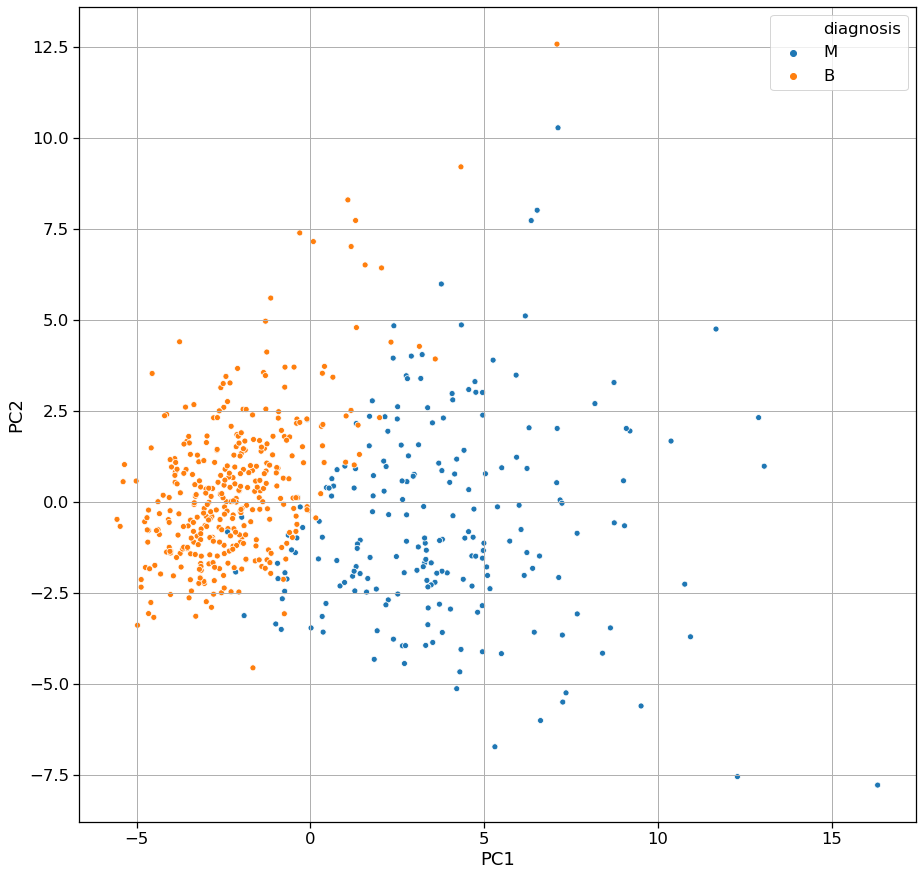

In [7]:
fig = plt.figure(figsize = (15,15))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.scatterplot(x="PC1", y="PC2", hue="diagnosis", data=PCA_df)
ax.grid()

**Realizar experimentos com o algoritmo k-NN**
- Variar valor de k
- Variar amostragem
    - random subsampling
    - 10-fold cross validation
    - Leave-one-out

Vamos carregar as funções necessárias para a implementação desta prática.
Lembrando que não estamos carregando as funções e pacotes que foram carregados anteriormente.

In [11]:
from sklearn.neighbors import KNeighborsClassifier # Carrega o algoritmo KNN para classificação
from sklearn.model_selection import ShuffleSplit # Carrega a função que será utilizada para fazer o Random Subsampling
from sklearn.model_selection import LeaveOneOut # Carrega a função que será utilizada para fazer o Leave-one-out
from sklearn.model_selection import KFold # Carrega a função que será utilizada para fazer o K-fold cross validation
from sklearn import metrics # Carrega a parte de métricas do sklearn
from sklearn.pipeline import make_pipeline # Função responsável por fazer o Pipeline do experimento
from sklearn.model_selection import cross_val_score # Função para extrair métricas de métodos de reamostragem
import numpy as np # Carrega o pacote numpy que conta com um conjunto completo de operações e funções matemáticas

Agora vamos criar uma função que tem como entrada os dados (atributos e valor alvo) e o método de reamostragem.
Ela irá aplicar o método de amostragem escolhido no conjunto de dados para diferentes valores de K como foi
proposto pelo enunciado da prática.
O objetivo aqui é observar como cada método de reamostragem se comporta quanto a estimativa do desempenho para
novos dados.

In [12]:
def reamostragem(X, y, metodo = "10fold"):
    results = list()
    
    k = [1,3,5,7,9,11,13,15,17,19,21,23,25,27]
    
    for i in k:
        if(metodo == "randsub"):
            ream = ShuffleSplit(n_splits=10, test_size=.25, random_state = 42)
        elif(metodo == "10fold"):
            ream = KFold(n_splits=10, shuffle = True, random_state = 42)
        elif(metodo == "loo"):
            ream = LeaveOneOut()

        model = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=i))
        ac = np.mean(cross_val_score(model, X, y, cv = ream, scoring = "accuracy"))
        results.append(ac)
    
    return results    

Na criação desta função temos um elemento interessante chamado **Pipeline**.
O Pipeline consiste em uma sequência de passos que podem ser relacionados a mudança de escala de atributos,
seleção de atributos, extração de atributos (exemplo: PCA), e o ajuste do modelo (fit).
Além de deixar o seu código mais elegante e limpo, a utilização dele evita que você esqueça de tomar algumas precauções.
Por exemplo:

Quando você faz a padronização dos dados no KNN, deve seguir os seguintes passos:
- Dividir os dados em treinamento e teste
- Ajustar a padronização aos dados de treinamento e aplicar a eles
- Quando for testar nos dados novos, aplicar a mesma normalização feita nos dados de entrada

Don't worry! O **Pipeline** faz isso automaticamente!

Um erro comum quando se está querendo estimar o desempenho do modelo é aplicar a normalização nos dados de treino e teste antes de particionar. Isso faz com que vocês tenha uma ideia pré-concebida sobre os dados de teste e é uma péssima prática.

Agora veremos o desempenho do modelo aplicando nossa função aos dados de Cancer de Mama de Wisconsin.

In [13]:
result_rand_sub = reamostragem(X_array, y_array, metodo = "randsub")
result_10fold = reamostragem(X_array, y_array, metodo = "10fold")
result_loo = reamostragem(X_array, y_array, metodo = "loo")
k = [1,3,5,7,9,11,13,15,17,19,21,23,25,27]

results_summary = pd.DataFrame({"Random Subsampling": result_rand_sub, "Leave-one-out": result_loo,
                               "10-fold": result_10fold, "k": k})

results_summary = results_summary.melt('k', var_name='cols',  value_name='Acurácia')

In [15]:
results_summary.tail()

,k,cols,Acurácia
37,19,10-fold,0.955984
38,21,10-fold,0.954229
39,23,10-fold,0.954229
40,25,10-fold,0.952475
41,27,10-fold,0.954229


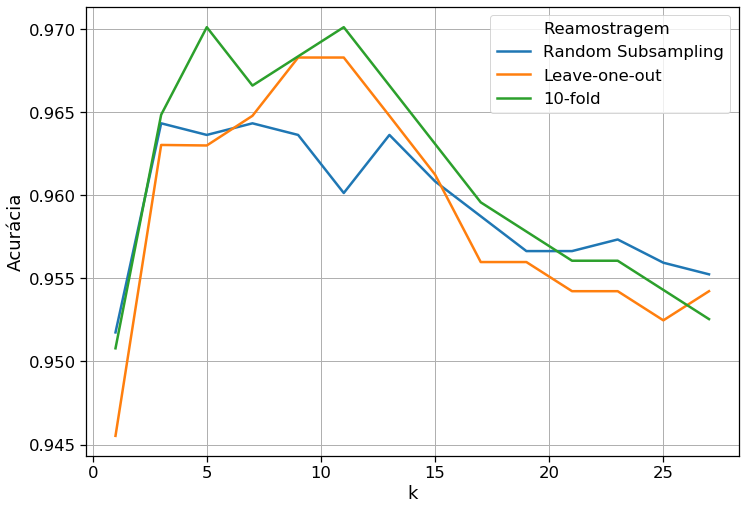

In [11]:
plt.figure(figsize=(11.7,8.27))
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
ax = sns.lineplot(x="k", y="Acurácia", hue="cols", data=results_summary)
# Aqui eu mudo o título da legenda
legend = ax.legend()
legend.texts[0].set_text("Reamostragem")
ax.grid()

Percebam que o comportamento do 10-fold se aproxima ao do LOO enquanto que o Random subsampling é diferente.
Agora vamos analizar o tempo de cada um.
Para isso vamos utilizar a biblioteca "timeit". Esta biblioteca é largamente utilizada para medir tempo de funções
devido à precisão que tem em desconsiderar os outros processos e verificar apenas o tempo que o computador está
utilizando para processar aquela função. É muito mais precisa que a biblioteca "time" para esta finalidade.

In [73]:
%timeit -r5 -n1 reamostragem(X_array, y_array, metodo = "randsub")

1.34 s ± 28.8 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [74]:
%timeit -r5 -n1 reamostragem(X_array, y_array, metodo = "10fold")

1.04 s ± 11 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [75]:
%timeit -r5 -n1 reamostragem(X_array, y_array, metodo = "loo")

35.1 s ± 483 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Como vocês podem perceber, por mais que teoricamente o Leave-one-out seja a melhor aproximação entre essas que estamos testando, seu tempo pode torná-lo proibitivo para bases maiores. Enquanto que o 10-fold cross validation obteve um tempo menor até que o random subsampling e um comportamento parecido com o do LOO. Isto torna o 10-fold uma boa escolha para avaliação de modelos. 

## Agora vamos para o próximo exercício

**Para um dado valor de k do algoritmo k-NN**
- Comparar k-NN com 3 variações do k-NN:
    - Utilizando 3 medidas de distância diferentes

Me empolguei na tutoria passada, quero criar minha própria distância!
Você pode criar a distância que você quiser e passar como métrica para o sklearn.
Como por exemplo a métrica "minha distância" que faz o contrário da norma máxima ou Chebyshev

\begin{equation}
dist_{chebyshev}( \vec{u}, \vec{v} ) = \max_{i = 1,~...~, m}(| u_i - v_i |) 
\end{equation}

\begin{equation}
dist_{minhadist}( \vec{u}, \vec{v} ) = \min_{i = 1,~...~, m}(| u_i - v_i |) 
\end{equation}

In [16]:
def minha_distancia(u, v):
    return np.min(np.absolute(u-v))

## Avaliação de performance e inferência bayesiana

### Aqui utilizaremos o 10-fold cross validation para analizar a performance

In [17]:
cv = KFold(n_splits=10, shuffle=True, random_state = 42)

model_1 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, metric = 'euclidean'))
performance_1 = cross_val_score(model_1, X_array, y_array, cv=cv, scoring = "accuracy")
print("Desempenho do modelo 1 em 10-fold cv")
print(performance_1)
print("Performance média do Modelo 1: "+str(np.mean(performance_1)))
print("Desvio padrão do Modelo 1: "+str(np.std(performance_1)))

print("-------------------")

model_2 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, metric = 'manhattan'))
performance_2 = cross_val_score(model_2, X_array, y_array, cv=cv, scoring = "accuracy")

print("Desempenho do modelo 2 em 10-fold cv")
print(performance_2)
print("Performance média do Modelo 2: "+str(np.mean(performance_2)))
print("Desvio padrão do Modelo 2: "+str(np.std(performance_2)))

print("-------------------")

model_3 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5, metric = minha_distancia))
performance_3 = cross_val_score(model_3, X_array, y_array, cv=cv, scoring = "accuracy")

print("Desempenho do modelo 3 em 10-fold cv")
print(performance_3)
print("Performance média do Modelo 3: "+str(np.mean(performance_3)))
print("Desvio padrão do Modelo 3: "+str(np.std(performance_3)))

Desempenho do modelo 1 em 10-fold cv
[0.92982456 0.98245614 0.98245614 1.         0.96491228 0.96491228
 0.98245614 0.96491228 0.94736842 0.91071429]
Performance média do Modelo 1: 0.963001253132832
Desvio padrão do Modelo 1: 0.02567945975605269
-------------------
Desempenho do modelo 2 em 10-fold cv
[0.94736842 0.98245614 0.98245614 1.         0.94736842 0.94736842
 0.98245614 0.98245614 0.96491228 0.92857143]
Performance média do Modelo 2: 0.9665413533834586
Desvio padrão do Modelo 2: 0.02163278965090902
-------------------
Desempenho do modelo 3 em 10-fold cv
[0.8245614  0.73684211 0.84210526 0.80701754 0.71929825 0.68421053
 0.87719298 0.73684211 0.66666667 0.80357143]
Performance média do Modelo 3: 0.7698308270676691
Desvio padrão do Modelo 3: 0.06706017881577805


Podemos observar que, em média, o desempenho do modelo com a distância de Manhattan ou City Block obteve o melhor desempenho. E nossa distância não foi tão legal :(
Mas será que tenho evidências suficientes para dizer que esse é o melhor modelo?

...

...

...

A resposta é: Não!

Agora vamos conhecer um pouco desta técnica chamada Teste Bayesiano Hierarquico para avaliarmos qual modelo obteve o melhor desempenho estatísticamente.

### Será que Bayes pode salvar nossa distância?

## Uma introdução ao Teste Bayesiano Hierarquico para comparação de modelos

Inferência estatística é toda uma área utilizada principalmente para mostrar estatísticamente se dois conjunto de objetos pertencem à mesma distribuição.

De longe, na tutoria não iremos discutir os pormenores dessa área.

Vamos trazer a intuição do teste e aplicá-lo ao nosso problema.

Suponha que você tem um dataset D e nele você aplica dois modelos A e B. Agora suponha que a diferença média entre eles é de 0.25 na acurácia em favor de A. Agora temos um novo dataset que é muito similar a D. Podemos dizer que o melhor modelo para o novo dataset é o A?

Não, esta é só uma medição específica em um dataset específico. Se repetirmos o experimento, poderíamos ter obtido várias diferenças - às vezes a diferença aumentará para 0.3, às vezes será tão baixo quanto 0.05 e às vezes B vencerá. Agora, imagine que extraímos 5000 amostras, como acima, e conte quantas vezes A ganhou. Se a diferença foi positiva (a favor de A) em 3000 casos, existe uma probabilidade de 60% de que A seja melhor.

Exceto que na inferência bayesiana não precisamos extrair 5000 amostras, pois podemos modelar a distribuição analiticamente e calcular o número esperado de vitórias para A. Isso é mais preciso e também mais rápido.

No começo, eu suponho que as duas distribuições são iguais, então é criada uma distribuição prévia. Depois é criada uma distribuição posterior com base em nossos resultados do cross validation. O modelo bayesiano hierarquico produz através de simulação um grande número (o padrão da baycomp é 50000) amostras a partir da distribuição posterior. Então é calculada a probabilidade a partir dessa distribuição posterior.

**E por que isso é diferente de testar a hipótese nula neste tipo de experimento?**

Se eu obtiver um p-value < 0.05, posso dizer que meu modelo A é melhor que o modelo B?

Resposta: não precisamente, obter um p-value de 0.05 não significa que há 95% de chance de que A seja melhor que B. Os testes bayesianos nos dão uma estimativa disso: a probabilidade de A ser melhor que B.

Para mais informações leia o artigo que propõe a biblioteca que utilizaremos: <https://repository.supsi.ch/7416/1/hierarchical.pdf>

## Agora vamos à prática

Vamos avaliar qual a probabilidade de um modelo ser melhor que o outro.

In [18]:
import baycomp


print(baycomp.two_on_single(performance_1, performance_2))
print(baycomp.two_on_single(performance_2, performance_3))
print(baycomp.two_on_single(performance_1, performance_3))

(0.2961032384763962, 0.7038967615236038)
(0.9999223863066333, 7.761369336667379e-05)
(0.9998662383806384, 0.00013376161936162756)


Segundo estes valores, existe uma evidência estatística de que o modelo 2 que usa a distância de Manhattan é melhor que os demais. E realmente nossa distância é a pior :(

### Região de equivalência

Uma outra vantagem do teste bayesiano hierarquico é que podemos definir uma região de equivalência, aqui chamada de "rope", entre os modelos. No caso vamos utilizar 0,5. Quando utilizamos esta região de equivalência estamos perguntando: A diferença entre o modelo A e o modelo B é de 0.5? Se a acurácia dos modelos diferir em menos de 0.5 os modelos são equivalentes.     

In [19]:
print(baycomp.two_on_single(performance_1, performance_2, rope = 0.1))
print(baycomp.two_on_single(performance_2, performance_3, rope = 0.1))
print(baycomp.two_on_single(performance_1, performance_3, rope = 0.1))

(2.821457851664767e-08, 0.9999999194944141, 5.2291007301974446e-08)
(0.9931884498279135, 0.00680851284075723, 3.0373313292253457e-06)
(0.9893992945393685, 0.010595410432915675, 5.29502771584589e-06)


(0.9931884498279135, 0.00680851284075723, 3.0373313292253457e-06)


/home/moises/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


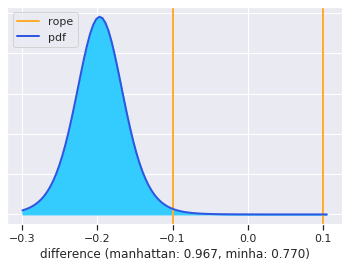

In [20]:
names = ("manhattan", "minha")
probs, fig = baycomp.two_on_single(performance_2, performance_3, rope=0.1, plot=True, names=names)
print(probs)
fig.show()

### Mas nem só de classificação vive o cientista de dados

Um fato interessante é que, além das medidas de classificação, existem várias medidas avaliação de desempenho em regressão. Vamos citar aqui as principais da qual a maioria das outras são derivadas:

**Erro Absoluto Médio, em inglês, Mean absolute error (MAE)**:

\begin{equation}
    MAE = \frac{\sum_{i=1}^{n}|y_{i}-\hat{y}_{i}|}{n}
\end{equation}

**Erro Quadrático Médio, em inglês, Mean Squared error (MSE)**:

\begin{equation}
    MSE = \frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^{2}}{n}
\end{equation}

In [18]:
redWine = pd.read_csv("winequality-red.csv", sep = ";")
redWine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [19]:
from sklearn.neighbors import KNeighborsRegressor # importa o KNN para regressão

X_wine =redWine.drop(["quality"], axis = 1)
y_wine = redWine["quality"]

In [21]:
import numpy as np

def minha_distancia(u, v):
    return np.min(np.absolute(u-v))

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

cv = KFold(n_splits=10, shuffle=True)

model_3 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5, metric = 'euclidean'))
performance_3 = cross_val_score(model_3, X_wine, y_wine, cv=cv, scoring = "neg_mean_absolute_error")
print("Desempenho do modelo 3 em 10-fold cv")
print(performance_3*(-1))
print("Performance média do Modelo 3: "+str(np.mean(performance_3*(-1))))
print("Desvio padrão do Modelo 3: "+str(np.std(performance_3*(-1))))

print("-------------------")

model_4 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5, metric = 'manhattan'))
performance_4 = cross_val_score(model_4, X_wine, y_wine, cv=cv, scoring = "neg_mean_absolute_error")
print("Desempenho do modelo 4 em 10-fold cv")
print(performance_4*(-1))
print("Performance média do Modelo 4: "+str(np.mean(performance_4*(-1))))
print("Desvio padrão do Modelo 4: "+str(np.std(performance_4*(-1))))

print("-------------------")

model_5 = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5, metric = minha_distancia))
performance_5 = cross_val_score(model_5, X_wine, y_wine, cv=cv, scoring = "neg_mean_absolute_error")
print("Desempenho do modelo 5 em 10-fold cv")
print(performance_5*(-1))
print("Performance média do Modelo 5: "+str(np.mean(performance_5*(-1))))
print("Desvio padrão do Modelo 5: "+str(np.std(performance_5*(-1))))

Desempenho do modelo 3 em 10-fold cv
[0.47625    0.505      0.5025     0.51875    0.52625    0.51375
 0.5375     0.5325     0.46375    0.47421384]
Performance média do Modelo 3: 0.5050463836477987
Desvio padrão do Modelo 3: 0.024519031077871446
-------------------
Desempenho do modelo 4 em 10-fold cv
[0.4975     0.50625    0.53625    0.49625    0.495      0.52125
 0.45875    0.505      0.49125    0.49559748]
Performance média do Modelo 4: 0.500309748427673
Desvio padrão do Modelo 4: 0.01916128310893921
-------------------
Desempenho do modelo 5 em 10-fold cv
[0.79125    0.85625    0.735      0.6875     0.79875    0.6725
 0.8725     0.77375    0.6825     0.79245283]
Performance média do Modelo 5: 0.766245283018868
Desvio padrão do Modelo 5: 0.06692861913068103


In [23]:
print(baycomp.two_on_single(performance_1, performance_2))
print(baycomp.two_on_single(performance_2, performance_3))
print(baycomp.two_on_single(performance_1, performance_3))

(0.43763058147779677, 0.5623694185222032)
(0.999999999999996, 3.9968028886505635e-15)
(0.9999999999999997, 3.3306690738754696e-16)


(0.999999999999996, 3.9968028886505635e-15)


/home/moises/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


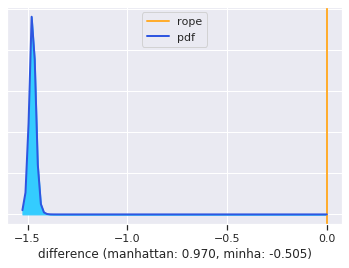

In [24]:
names = ("manhattan", "minha")
probs, fig = baycomp.two_on_single(performance_2, performance_3, plot=True, names=names)
print(probs)
fig.show()

![Thatsall](https://media.giphy.com/media/JLtQeoVXD5yKI/giphy.gif)